<a href="https://colab.research.google.com/github/fernandoCotti/twitterRecomendationSystem/blob/main/tp_final_sistemas_de_recomendaci_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importamos todas las librerías y cargamos los dataframes subidos en docs.

In [ ]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed

# Cargar datos
tweets_url = '1KDr18vJnv1uq8DkvhQ29ysbCAT82lnMrrN3t7HV-N8k'
to_predict_url = '1n_W6dGd4tfWfRM2bIEAVhCaQcuh1XvNpc1Nzljd3hKE'
ground_truth_url = '1iqD79i90RZ2LwOFKTnLubIOi9dctRQdKBu73-XPZPPI'

tweets_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{tweets_url}/export?format=csv")
to_predict_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{to_predict_url}/export?format=csv")
ground_truth_df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{ground_truth_url}/export?format=csv")

print("Tweets DataFrame:")
print(tweets_df.head())

print("\nTo Predict DataFrame:")
print(to_predict_df.head())

print("\nGround Truth DataFrame:")
print(ground_truth_df.head())


Tweets DataFrame:
             tweet_id    user_id  \
0  900823742401699842  334537201   
1  902378409384431616  334537201   
2  897841296580235264  334537201   
3  897841383658205185  334537201   
4  897840931365408768  334537201   

                                                text  favorites  retweets  \
0  RT @TwitchyTeam: Wait, WHAT!? Time Mag wants y...          0         7   
1  RT @MarkSimoneNY: Scientist Shuts Down CNN Hos...          0       219   
2  RT @MarkSimoneNY: Watch Donald Trump Disavowin...          0       189   
3  RT @MarkSimoneNY: White Supremacists actually ...          0       424   
4  RT @MarkSimoneNY: Now the Left Wing PC Nutjobs...          0       185   

   is_reply  is_retweet  is_original  mentions  media  hashtags  
0     False        True        False         1      0         0  
1     False        True        False         1      0         0  
2     False        True        False         1      0         0  
3     False        True        False  

## Creamos el grafo dirigido de los tweets en base a la interacción de los usuarios


---



---



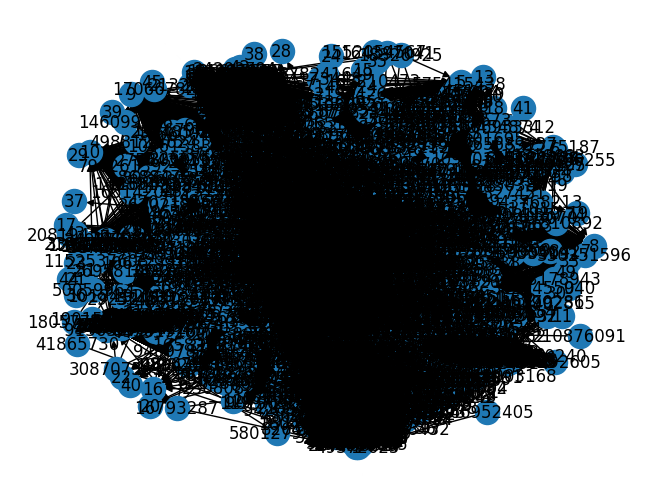

In [ ]:
import networkx as nx

# Creamos el grafo dirigido con la librería
G = nx.DiGraph()

# Agregamos los nodos y arcos al grafo según la interacción entre usuarios
for _, row in tweets_df.iterrows():
    G.add_edge(row['user_id'], row['mentions'], weight=row['retweets'])

# Iteramos a través del dataframe para conectar los nodos, para cada fila, se agrega un arco al grafo G.
# La función add_edge lo que hace es agregar un arco entre dos nodos. Los nodos serían los user_id y mentions de la fila actual del dataframe.
# Weight sería el valor de retweets, que es la cantidad de veces que un usuario menciona o responde a otro usuario en un tweet.

# Impresión del grafo creado
nx.draw(G, with_labels=True)



# Cálculo de la relación entre tweets

---

---





In [ ]:
def content_similarity(tweet1, tweet2): # Calcula la similitud entre dos tweets viéndolos como conjuntos de palabras únicas y buscando la intersección de los mismos,
# y desoués medimos la proporción de palabras en común entre los tweets respecto al total de palabras únicas en ambos.
    text1 = set(tweet1.lower().split()) # Acá creamos los conjuntos, eliminando las duplicaciones para hacer más fácil el cálculo de la intersección.
    text2 = set(tweet2.lower().split())
    intersection_len = len(text1.intersection(text2)) # Buscamos la intersección entre los conjuntos que creamos antes.
    return intersection_len / (len(text1) + len(text2) - intersection_len) #


## Generación de las características de contenido


---



---



In [ ]:
# Preprocesamos los tweets para crear un diccionario que mapee user_id a sus tweets
tweets_por_usuario = tweets_df.groupby('user_id')['text'].apply(list).to_dict()
# Las claves son los IDs de usuario y los valores son listas de tweets asociados a cada usuario.
# Esto se logra utilizando el método groupby de pandas para agrupar los tweets por ID de usuario y luego convertirlos en listas.


# Después definimos la función generate_content_features, que recibe dos IDs de usuario como nodos u y v, y busca los tweets más recientes asociados con esos usuarios en el diccionario que hicimos anteriormente.
# Calculamos la similitud de contenido entre estos tweets usando la función content_similarity que devuelve un diccionario con el valor de la similitud calculada en 'content_similarity'.

def generate_content_features(u, v): # Se calcula la similitud de contenido entre los tweets de dos usuarios pasados por parámetro
                                     # y devuelve un diccionario de características que contiene la similitud de contenido como una característica.
    tweets_u = tweets_por_usuario.get(u, [])
    tweets_v = tweets_por_usuario.get(v, [])

    last_tweet_u = tweets_u[-1] if tweets_u else ''
    last_tweet_v = tweets_v[-1] if tweets_v else ''

    content_similarity_score = content_similarity(last_tweet_u, last_tweet_v)

    return {'content_similarity': content_similarity_score}

# Esta función sirve para generar características de contenido entre pares de usuarios que después vamos a usar en el modelo de aprendizaje automático.

## Obtención de la muestra


---



---



In [ ]:
sample_size = 500  # Tamaño de la muestra
to_predict_df_sample = to_predict_df.sample(n=sample_size, random_state=42)  # Seleccionar una muestra aleatoria
# Se define sample_size como el tamaño deseado de la muestra y luego se utiliza el método sample de pandas para
# seleccionar aleatoriamente una muestra de to_predict_df con el tamaño especificado.

# Generamos características de contenido para cada par de nodos en paralelo utilizando la muestra
training_data_sample = Parallel(n_jobs=-1)(delayed(generate_content_features)(row['origen'], row['destino'])
                                            for _, row in to_predict_df_sample.iterrows())

# Buscamos las truth lables para la muestra de pares de nodos, usando la función de pandas "apply" aplicado al dataframe original.
# Realizamos esto como un preprocesamiento para preparar los datos para su uso en el entrenamiento y evaluación de modelos de aprendizaje automático.
ground_truth_labels_sample = to_predict_df_sample.apply(lambda row: ground_truth_df.loc[
    (ground_truth_df['origen'] == row['origen']) & (ground_truth_df['destino'] == row['destino']),
    'exists'].values[0], axis=1)




## Entrenamiento y evaluación del modelo utilizando la muestra anteriormente obtenida

In [ ]:
# Dividmos la características y las etiquetas en conjuntos de entrenamiento (para el entrenamiento) y validación (para evaluar el rendimiento)
# (X_train, Y_train, X_val, Y_val) con split.
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(training_data_sample, ground_truth_labels_sample, test_size=0.2, random_state=42)

# Con DictVectorizer transformamos los diccionarios de características en matrices numéricas para entrenar el modelo,
# porque para el entrenamiento es necesario tener datos numéricos.
vectorizer = DictVectorizer()
X_train_numeric_sample = vectorizer.fit_transform(X_train_sample)
X_val_numeric_sample = vectorizer.transform(X_val_sample)

# Entrenamos el modelo con la muestra de entrenamiento
# Se hace el entrenamiento con RandomForestClassifier, usando las características y las etiquetas del entrenamiento.
model = RandomForestClassifier()
model.fit(X_train_numeric_sample, y_train_sample)

# Realizamos las predicciones en la muestra de validación
# El modelo aplica las reglas que aprendió en el entrenamiento para predecir las etiquetas de salida que les corresponderían a cada característica.
y_pred_sample = model.predict(X_val_numeric_sample)

In [ ]:
# Calculamos las métricas de evaluación para k=5, k=10 y k=20 en la muestra de validación
# Nos sirven para evaluar el rendimiento del modelo
# La precisión es el número de predicciones correctas dividido el número total de predicciones, usando k = 5, 10 y 20,
# considerando las predicciones más relevantas solamente. El parámetro k serían la cantidad de elementos que se consideran en la evaluación como tal.
# Por ejemplo, si k = 5, solo tenemos en cuenta los primeros 5 elementos recomendados para calcular las métricas.
precision_at_k_sample = precision_score(y_val_sample, y_pred_sample, average=None)
# El recall es el número de predicciones correctas dividido por el número total de elementos relevantes, también para cada valor de k.
recall_at_k_sample = recall_score(y_val_sample, y_pred_sample, average=None)
# El nDCG evalua la relevancia de los elementos que devuelve el modelo, haciendo que pesen más las predicciones correctas al principio de la lista de recomendaciones.
# Se calcula con la fórmula de DCG / IDCG (valor ideal), también para cada valor de k.
ndcg_at_k_5_sample = ndcg_score([y_val_sample], [y_pred_sample], k=5)
ndcg_at_k_10_sample = ndcg_score([y_val_sample], [y_pred_sample], k=10)
ndcg_at_k_20_sample = ndcg_score([y_val_sample], [y_pred_sample], k=20)

print("Precision@5:", precision_at_k_sample)
print("Recall@5:", recall_at_k_sample)
print("nDCG@5:", ndcg_at_k_5_sample)
print("nDCG@10:", ndcg_at_k_10_sample)
print("nDCG@20:", ndcg_at_k_20_sample)

Precision@5: [1.]
Recall@5: [1.]
nDCG@5: 0.0
nDCG@10: 0.0
nDCG@20: 0.0
